In [1]:
!pip install tensorflow --quiet
!pip install tensorflow-hub --quiet
!pip install tensorflow-text --quiet
!pip install transformers --quiet

In [2]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,TFRobertaModel

tf.get_logger().setLevel('ERROR')
pd.set_option('display.max_colwidth', None)
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## Preprocess the Dataset

Here, we are going to use the same set of pre-processing steps we used in [one of the previous notebooks](https://www.kaggle.com/code/l048596/disaster-tweets-classifier-using-bert). You can find a detailed explanation of the steps in the link.

In [4]:
duplicates = train[train.duplicated('text')]
problematic_duplicates = []

for i in range(duplicates.text.nunique()):
    duplicate_subset = train[train.text == duplicates.text.unique()[i]]
    if len(duplicate_subset) > 1 and duplicate_subset.target.nunique() == 2:
        problematic_duplicates.append(i)
        
print(problematic_duplicates)

[4, 7, 12, 15, 24, 26, 33, 34, 35, 36, 38, 39, 42, 44, 46, 51, 55, 58]


In [5]:
target_list = [0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0]

for problematic_index in range(len(problematic_duplicates)): 
    train.target = np.where(train.text == duplicates.text.unique()[problematic_index], 
                            target_list[problematic_index], train.target)

In [6]:
def clean_text(dataframe):
    dataframe.text = dataframe.text.apply(lambda x: str.lower(x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'http\S+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'#', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'@\S+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\n', '', x))
    return(dataframe)

In [7]:
clean_train = clean_text(train)
clean_train_balanced = clean_train.groupby('target').sample(3000, random_state = 1048596)

In [8]:
clean_train_balanced.sample(frac = 1).head(5)

,id,keyword,location,text,target
2180,3124,debris,"Hamilton, Ontario Canada",malaysia seem more certain than france.plane debris is from missing mh370,1
7152,10249,volcano,NaN,this la startup is so hot that their flowers come straight from a volcano via,0
6239,8908,snowstorm,Australia,bring back games from the past. snowstorm. tic tac toe. battleships. fast food. matchwood.,1
5716,8158,rescuers,NaN,video: 'we're picking up bodies from water': rescuers are searching for hundreds of migrants in the mediterranean after a boat carryi...,1
289,423,apocalypse,NaN,and that's because on my planet it's the lone audience of the apocalypse!,0


In this notebook, we are going to use **train_test_split** instead of **np.split** to split our dataset into training and validation datasets. This just helps us better reference the texts and labels to use when training the model. 

In [9]:
x_train, x_val, y_train, y_val = train_test_split(clean_train_balanced.text, 
                                                  clean_train_balanced.target, 
                                                  train_size = 0.85, 
                                                  random_state = 1048596)

The biggest change in this iteration is the tokenizer and the BERT model we are going to fine-tune for the classification task. So far, we have been using BERT-base and Small-BERT models that are made available through tensorflow hub. However, given that we are attempting to classify tweets, there may be pre-trained models that are more appropriate for the purpose of classifying tweets. **BERTweet** is a pre-trained language model designed forr English tweets and have been shown to perform better compared to other state-of-the-art language models for many NLP tasks including text classification. 

In [10]:
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', 
                                          normalization = True, 
                                          use_fast = False,
                                          add_special_tokens = True,
                                          pad_to_max_length = True,
                                          return_attention_mask = True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
train_token = tokenizer(x_train.tolist(), 
                        padding = "max_length", 
                        truncation = True).data

val_token = tokenizer(x_val.tolist(),
                      padding = "max_length", 
                      truncation = True).data

In [12]:
def extract_features(tokens, labels, batch_size):
    features = {x: tokens[x] for x in tokenizer.model_input_names}
    features = tf.data.Dataset.from_tensor_slices((features, labels))
    return features.shuffle(len(labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_features = extract_features(train_token, y_train, 32)
val_features = extract_features(val_token, y_val, 32)

In our new model, we are going to use both the **input_ids** and **attention_masks** as the input of our model. Attention mask indicates which token(s) the model should pay attention to. The two inputs will go through the **BERTweet** model layer and the output of this layer with go through the Dense layer with the Sigmoid activation function. We are also going to make change to our optimizer, from Adam to AdamW, because AdamW is known to yield better training loss and the model tends to generalize better compared to the model trained using the Adam optimizer.

In [13]:
bert_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

input_ids = tf.keras.Input(shape=(128,), dtype = 'int32', name = 'input_ids')
attention_masks = tf.keras.Input(shape=(128,), dtype ='int32', name = 'attention_mask')

output = bert_model([input_ids, attention_masks])[1]
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(output)

model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)

model.compile(optimizer = tf.keras.optimizers.AdamW(weight_decay = 1e-6, learning_rate = 1e-5), 
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['accuracy'])

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


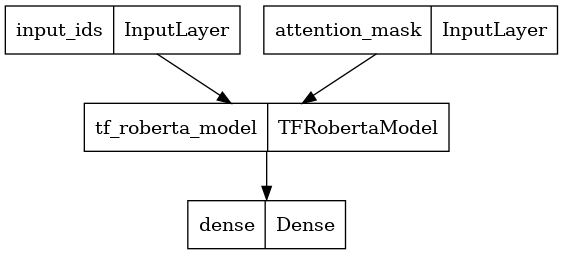

In [14]:
plot_model(model)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [16]:
history = model.fit(train_features, 
                    epochs = 3,
                    validation_data = val_features,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


160/160 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.7978
Epoch 1: val_loss improved from inf to 0.40642, saving model to model/best_performed_model.ckpt
160/160 [==============================] - 145s 597ms/step - loss: 0.4659 - accuracy: 0.7978 - val_loss: 0.4064 - val_accuracy: 0.8300
Epoch 2/3
160/160 [==============================] - ETA: 0s - loss: 0.3486 - accuracy: 0.8592
Epoch 2: val_loss did not improve from 0.40642
160/160 [==============================] - 83s 519ms/step - loss: 0.3486 - accuracy: 0.8592 - val_loss: 0.4162 - val_accuracy: 0.8256
Epoch 3/3
160/160 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.8859
Epoch 3: val_loss did not improve from 0.40642
160/160 [==============================] - 82s 513ms/step - loss: 0.2987 - accuracy: 0.8859 - val_loss: 0.4364 - val_accuracy: 0.8244


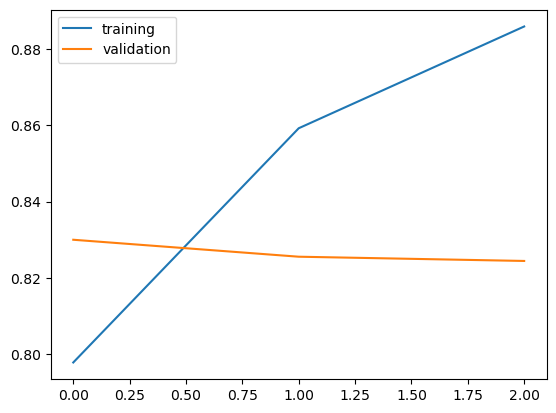

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

## Prepare for Submission

In [18]:
clean_test = clean_text(test)

test_token = tokenizer(clean_test.text.tolist(), 
                       padding = "max_length", 
                       truncation = True,
                       return_tensors='tf').data

In [19]:
predictions = model.predict(test_token)

102/102 [==============================] - 20s 169ms/step


In [20]:
final_predictions = [(x > 0.5).astype(int)[0] for x in predictions]
predictions_df = pd.DataFrame(list(zip(test.id, final_predictions)),
                              columns = ['id', 'target'])

predictions_df.to_csv('predictions.csv', index = False)